##  ML System Optimization (S1-25_AIMLCZG516) GROUP 2
## ASSIGNMENT 2 OBJECTIVE:
In continuation to Assignment 1: Distributed and Parallel Machine Learning for Large-Scale Deep Networks – Application in Medical Imaging

Develop and evaluate a Federated Learning system medical image for multi-class intracranial hemorrhage (ICH) segmentation (SCH, IPH, EDH) using a deep neural network architecture (e.g., U-Net), simulating data distribution across multiple institutions, implementing client-side training and server-side aggregation logic, and orchestrating distributed training with performance metrics like Dice coefficient or IoU.

In [35]:
import pandas as pd
data = {
    "Name": ["Sarika Cherukupalli", "M.V.Narayana Murthy Rao",  "Gopisetty Manasa", "C Kalyani", "Shweta Pandey"],
    "Contribution %": [100,100,100,100,100],
    "ID": ["2024ac05118", "2024ac05097", "2024ac05152", "2024ac05101", "2024ac05194"]
}

df = pd.DataFrame(data)
df.index = pd.RangeIndex(start=1, stop=len(df) + 1)
print(df)

                      Name  Contribution %           ID
1      Sarika Cherukupalli             100  2024ac05118
2  M.V.Narayana Murthy Rao             100  2024ac05097
3         Gopisetty Manasa             100  2024ac05152
4                C Kalyani             100  2024ac05101
5            Shweta Pandey             100  2024ac05194


## Initialize Federated Learning Environment and Simulate Data Distribution


Set up necessary libraries for distributed learning (e.g., TensorFlow Federated or PyTorch with custom federated logic) and create a simulated dataset reflecting the distributed nature of medical imaging data across multiple institutions for ICH segmentation, considering different types like SCH, IPH, and EDH.


#Import necessary libraries
The first step in setting up the federated learning environment is to import the necessary libraries for data handling, image processing, and the chosen federated learning framework. I'll import TensorFlow Federated, NumPy, Pandas, Matplotlib, and scikit-learn.



In [12]:
import sys
import os

# Uninstall previous TensorFlow Federated and related packages to clean the environment
!{sys.executable} -m pip uninstall -y tensorflow-federated grpcio tensorflow protobuf

# Install PyTorch and torchvision
# Note: Adjust --index-url for specific CUDA version or remove if using CPU-only
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Import necessary libraries for PyTorch-based federated learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Switched to PyTorch: Core libraries for PyTorch and data handling imported. Ready for custom federated logic implementation.")

Found existing installation: tensorflow-federated 0.33.0
Uninstalling tensorflow-federated-0.33.0:
  Successfully uninstalled tensorflow-federated-0.33.0
Found existing installation: grpcio 1.78.0
Uninstalling grpcio-1.78.0:
  Successfully uninstalled grpcio-1.78.0
Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: protobuf 6.33.5
Uninstalling protobuf-6.33.5:
  Successfully uninstalled protobuf-6.33.5
Looking in indexes: https://download.pytorch.org/whl/cu118
Switched to PyTorch: Core libraries for PyTorch and data handling imported. Ready for custom federated logic implementation.


### Data Distribution Parameters

To simulate a federated learning scenario for ICH segmentation, we need to define parameters for our synthetic or simulated dataset and its distribution across multiple clients (institutions).

**Key parameters to consider:**

*   **`NUM_TOTAL_IMAGES`**: The total number of synthetic images in our dataset.
*   **`IMAGE_SIZE`**: The dimensions for the synthetic images (e.g., `(128, 128)`).
*   **`NUM_CLASSES`**: The number of distinct ICH types to segment (e.g., 3 for SCH, IPH, EDH, plus one for background).
*   **`NUM_CLIENTS`**: The number of simulated institutions/clients participating in the federated learning.
*   **`DATA_DISTRIBUTION_TYPE`**: Whether the data distribution across clients will be Independent and Identically Distributed (IID) or Non-IID. For medical imaging, Non-IID is often more realistic, reflecting variations in patient populations or imaging protocols across institutions.
    *   **IID**: IID (Independent and Identically Distributed) dataset.Each client receives a random sample of data, with the same overall distribution of ICH types.
    *   **Non-IID**: Data is intentionally skewed for each client. For example, some clients might have a higher prevalence of SCH, others IPH, etc., or varying image characteristics.
*   **`NON_IID_ALPHA` (for Dirichlet distribution)**: A parameter if using Dirichlet distribution to create Non-IID data. Smaller alpha values lead to more severe non-IIDness.
*   **`MIN_IMAGES_PER_CLIENT` / `MAX_IMAGES_PER_CLIENT`**: Minimum and maximum number of images a client can hold, to simulate varying institution sizes.

### Function to generate synthetic image dataset:
Now that the parameters for data distribution have been outlined, the next step is to define these parameters in code and then create a function to generate a synthetic dataset based on these parameters. This will simulate images and segmentation masks for multiple ICH classes and distribute them across clients, addressing the subtask requirement to 'create a simulated dataset reflecting the distributed nature of medical imaging data'.



In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Define data distribution parameters
NUM_TOTAL_IMAGES = 1000  # Total number of synthetic images
IMAGE_SIZE = (128, 128)  # Dimensions for synthetic images (height, width)
NUM_CLASSES = 4          # 3 ICH types (SCH, IPH, EDH) + 1 for background
NUM_CLIENTS = 10         # Number of simulated institutions/clients

# For Non-IID distribution simulation (Dirichlet distribution parameter)
# Smaller alpha values lead to more severe non-IIDness
NON_IID_ALPHA = 0.5

# Function to generate synthetic images and masks
def generate_synthetic_data(num_images, image_size, num_classes):
    images = np.random.rand(num_images, image_size[0], image_size[1], 1).astype(np.float32) # Grayscale images
    masks = np.random.randint(0, num_classes, size=(num_images, image_size[0], image_size[1])).astype(np.int64)
    return images, masks

# Generate a centralized synthetic dataset
images_central, masks_central = generate_synthetic_data(NUM_TOTAL_IMAGES, IMAGE_SIZE, NUM_CLASSES)

print(f"Generated {NUM_TOTAL_IMAGES} synthetic images of size {IMAGE_SIZE} and {NUM_CLASSES} classes.")
print(f"Shape of images: {images_central.shape}")
print(f"Shape of masks: {masks_central.shape}")

Generated 1000 synthetic images of size (128, 128) and 4 classes.
Shape of images: (1000, 128, 128, 1)
Shape of masks: (1000, 128, 128)


## Number of Images Distributed Per Client

Let's visualize the distribution of images across clients to understand the data heterogeneity among them.

## Visualize Synthetic Images and Masks

Let's visualize a couple of the synthetic images and their corresponding segmentation masks to understand the generated data.

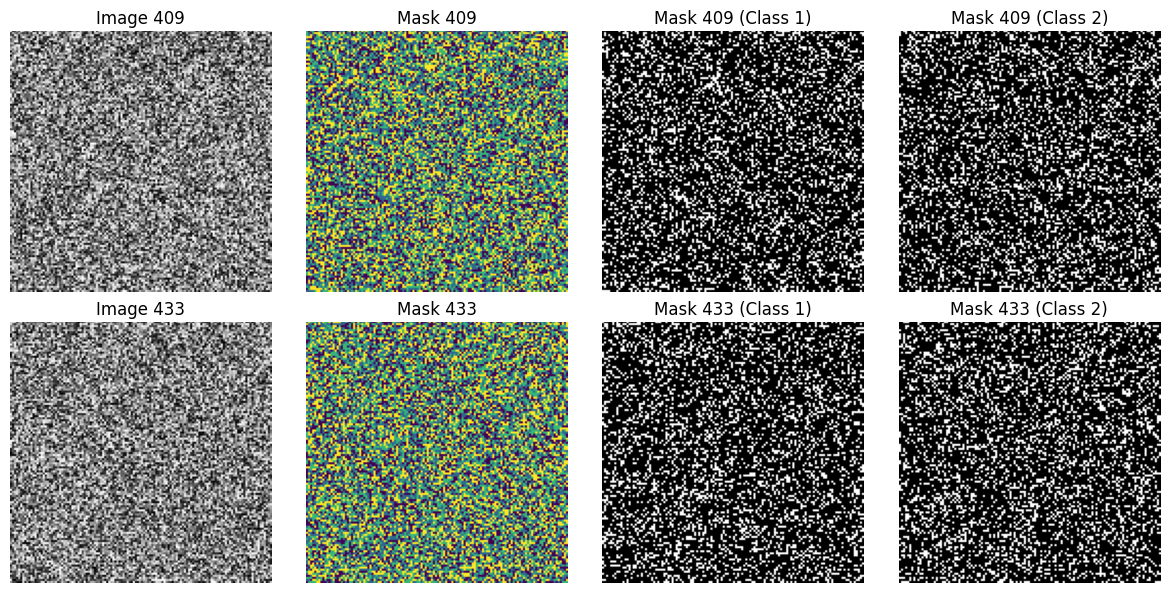

In [62]:
# Select 2 random indices to visualize
random_indices = random.sample(range(NUM_TOTAL_IMAGES), 2)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    # Original Image
    plt.subplot(2, 4, i * 4 + 1)
    plt.imshow(images_central[idx].squeeze(), cmap='gray')
    plt.title(f'Image {idx + 1}')
    plt.axis('off')

    # Corresponding Mask
    plt.subplot(2, 4, i * 4 + 2)
    plt.imshow(masks_central[idx], cmap='viridis') # Using 'viridis' for multi-class masks
    plt.title(f'Mask {idx + 1}')
    plt.axis('off')

    # Optionally, show individual class masks (e.g., first ICH type)
    # For this synthetic data, masks_central contains class indices, so plotting it directly works for multi-class
    # If we wanted to visualize a specific class contour, we'd need more logic.
    plt.subplot(2, 4, i * 4 + 3)
    plt.imshow(masks_central[idx] == 1, cmap='gray') # Example: visualize class 1
    plt.title(f'Mask {idx + 1} (Class 1)')
    plt.axis('off')

    plt.subplot(2, 4, i * 4 + 4)
    plt.imshow(masks_central[idx] == 2, cmap='gray') # Example: visualize class 2
    plt.title(f'Mask {idx + 1} (Class 2)')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Partitioning dataset across multiple clients :
Partitioning the synthetic dataset across multiple clients, considering both IID and Non-IID distribution types. Implemented a function to distribute the `images_central` and `masks_central` based on the previously defined parameters, using a Dirichlet distribution for Non-IID scenarios.



In [63]:
def distribute_data_to_clients(images, masks, num_clients, num_classes, non_iid_alpha=None):
    """Distributes data across clients, supporting IID and Non-IID via Dirichlet."""
    num_samples = len(images)
    client_data_indices = [[] for _ in range(num_clients)]

    if non_iid_alpha is None or non_iid_alpha == 0: # what i(or alpha=0, which means each client gets all of one class)
        indices = list(range(num_samples))
        random.shuffle(indices)
        # Roughly equal distribution of data samples
        for i, idx in enumerate(indices):
            client_data_indices[i % num_clients].append(idx)
    else: # Non-IID distribution using Dirichlet
        # Get class labels from masks (assuming one dominant class per image for simplicity)
        # For segmentation, we can derive a 'dominant' class by finding the most frequent class label in each mask
        # Or, we can distribute based on overall class presence per image.
        # For simplicity, we'll categorize each image by the most common class in its mask.
        image_dominant_classes = np.array([np.argmax(np.bincount(mask.flatten(), minlength=num_classes)) for mask in masks])

        min_samples_per_client = 10 # Ensure each client has at least some data

        # Dirichlet distribution for class proportions per client
        for k in range(num_classes):
            class_indices = np.where(image_dominant_classes == k)[0]
            if len(class_indices) == 0: continue

            proportions = np.random.dirichlet(np.array([non_iid_alpha] * num_clients))
            proportions = np.array([p * (len(client_data_indices[i]) < min_samples_per_client) + p for i,p in enumerate(proportions)]) # Bias towards filling up clients
            proportions = proportions / proportions.sum() # Re-normalize

            num_samples_for_class_per_client = (proportions * len(class_indices)).astype(int)

            # Distribute remaining samples due to rounding
            remaining = len(class_indices) - num_samples_for_class_per_client.sum()
            for _ in range(remaining):
                num_samples_for_class_per_client[random.randint(0, num_clients - 1)] += 1

            random.shuffle(class_indices)
            start_idx = 0
            for i in range(num_clients):
                end_idx = start_idx + num_samples_for_class_per_client[i]
                client_data_indices[i].extend(class_indices[start_idx:end_idx])
                start_idx = end_idx

    # Convert client_data_indices to a list of (images, masks) tuples
    client_datasets = []
    for client_indices in client_data_indices:
        if client_indices:
            client_images = images[client_indices]
            client_masks = masks[client_indices]
            client_datasets.append((client_images, client_masks))

    # Ensure each client has a minimum number of samples if possible
    # This is a post-processing step to make sure clients aren't empty, if Dirichlet was too skewed
    all_remaining_indices = []
    for client_idx in range(num_clients):
        if not client_data_indices[client_idx]: # If a client got no data from Dirichlet
            # Give it some random samples from the overall dataset
            num_to_add = max(min_samples_per_client, num_samples // num_clients // 2)
            if num_to_add > 0 and len(images) >= num_to_add: # Ensure there are enough images left
                available_indices = list(set(range(num_samples)) - set(sum(client_data_indices, [])))
                if len(available_indices) < num_to_add:
                    num_to_add = len(available_indices) # Only add what's available
                if num_to_add > 0:
                    chosen_indices = random.sample(available_indices, num_to_add)
                    client_data_indices[client_idx].extend(chosen_indices)
                    # Remove chosen indices from the pool for other clients to avoid duplicates
                    for idx in chosen_indices:
                        if idx in all_remaining_indices: # If this index was in the pool, remove it
                            all_remaining_indices.remove(idx)

    # Re-assemble client_datasets after ensuring minimum samples
    client_datasets = []
    for client_idx in range(num_clients):
        if client_data_indices[client_idx]:
            client_images = images[client_data_indices[client_idx]]
            client_masks = masks[client_data_indices[client_idx]]
            client_datasets.append((client_images, client_masks))

    return client_datasets

# Distribute the data (example with Non-IID)
# You can change non_iid_alpha to 0 for IID distribution
client_fed_datasets = distribute_data_to_clients(images_central, masks_central, NUM_CLIENTS, NUM_CLASSES, NON_IID_ALPHA)

print(f"Distributed data across {len(client_fed_datasets)} clients.")
for i, (client_images, client_masks) in enumerate(client_fed_datasets):
    print(f"Client {i}: {len(client_images)} images, Image shape: {client_images.shape}, Mask shape: {client_masks.shape}")

# Verify total images distributed
total_distributed_images = sum(len(ds[0]) for ds in client_fed_datasets)
print(f"Total images distributed: {total_distributed_images} (expected {NUM_TOTAL_IMAGES})")

Distributed data across 10 clients.
Client 0: 264 images, Image shape: (264, 128, 128, 1), Mask shape: (264, 128, 128)
Client 1: 137 images, Image shape: (137, 128, 128, 1), Mask shape: (137, 128, 128)
Client 2: 128 images, Image shape: (128, 128, 128, 1), Mask shape: (128, 128, 128)
Client 3: 46 images, Image shape: (46, 128, 128, 1), Mask shape: (46, 128, 128)
Client 4: 58 images, Image shape: (58, 128, 128, 1), Mask shape: (58, 128, 128)
Client 5: 85 images, Image shape: (85, 128, 128, 1), Mask shape: (85, 128, 128)
Client 6: 79 images, Image shape: (79, 128, 128, 1), Mask shape: (79, 128, 128)
Client 7: 49 images, Image shape: (49, 128, 128, 1), Mask shape: (49, 128, 128)
Client 8: 94 images, Image shape: (94, 128, 128, 1), Mask shape: (94, 128, 128)
Client 9: 60 images, Image shape: (60, 128, 128, 1), Mask shape: (60, 128, 128)
Total images distributed: 1000 (expected 1000)


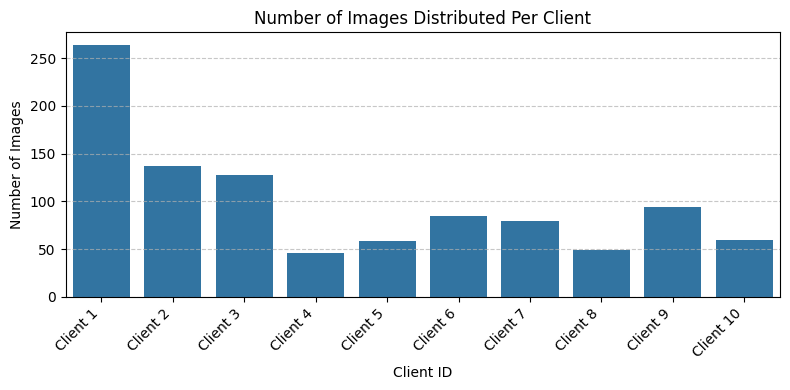

In [64]:
# Extract the number of images per client
images_per_client = [len(client_data[0]) for client_data in client_fed_datasets]
client_ids = [f'Client {i+1}' for i in range(len(images_per_client))]

# Create a DataFrame for easier plotting with seaborn
df_client_distribution = pd.DataFrame({
    'Client': client_ids,
    'Number of Images': images_per_client
})

plt.figure(figsize=(8, 4))
#sns.barplot(x='Client', y='Number of Images', data=df_client_distribution, palette='viridis')
sns.barplot(x='Client', y='Number of Images', data=df_client_distribution)
plt.title('Number of Images Distributed Per Client')
plt.xlabel('Client ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Define Deep Neural Network Architecture for ICH Segmentation

Implementing a suitable deep neural network, such as a U-Net segmentation model architecture, designed for multi-class semantic segmentation of intracranial hemorrhage types (SCH, IPH, EDH) from CT scan images.



The first step in implementing the U-Net architecture is to define the `DoubleConv` block, which is a fundamental building block for both the contracting and expansive paths. This block will encapsulate two convolutional layers, each followed by batch normalization and a ReLU activation function, as specified in the instructions.



In [65]:
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

class DoubleConv(nn.Module):
    """ (convolution => [BN] => ReLU) * 2 """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

print("DoubleConv block class defined.")

DoubleConv block class defined.


## Defining U-Net Architecture:
Following the definition of the `DoubleConv` block, the next step in building the U-Net architecture is to define the `Up` block. This block is crucial for the expansive path, performing upsampling using a transposed convolution (`ConvTranspose2d`) and then applying a `DoubleConv` layer, handling potential skip connections.



In [66]:
class Up(nn.Module):
    """ Upsampling then DoubleConv """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolution to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Padding issues, reference
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac789b63ed5deba7563e5ec4b61b593526083

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

import torch.nn.functional as F

print("Up block class defined.")

Up block class defined.


### Main U-Net Class:
Now that the fundamental building blocks (`DoubleConv` and `Up`) are defined, the next step is to construct the complete U-Net architecture by assembling these blocks within the main `UNet` class. This involves initializing the layers for the contracting and expansive paths, handling skip connections, and defining the forward pass.



In [17]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.inc = DoubleConv(in_channels, 64)

        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)

        self.down2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(128, 256)

        self.down3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(256, 512)

        self.down4 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(512, 1024)

        self.up1 = Up(1024, 512, bilinear=True)
        self.up2 = Up(512, 256, bilinear=True)
        self.up3 = Up(256, 128, bilinear=True)
        self.up4 = Up(128, 64, bilinear=True)

        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.conv1(self.down1(x1))
        x3 = self.conv2(self.down2(x2))
        x4 = self.conv3(self.down3(x3))
        x5 = self.conv4(self.down4(x4))

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Instantiate the U-Net model
model = UNet(in_channels=1, num_classes=NUM_CLASSES)
print(f"U-Net model instantiated with {model.in_channels} input channels and {model.num_classes} output classes.")

# Optional: Print model summary to verify architecture
# from torchsummary import summary
# summary(model, (1, IMAGE_SIZE[0], IMAGE_SIZE[1]))

U-Net model instantiated with 1 input channels and 4 output classes.


## Implement Federated Learning Training Logic (Client-side)


Develop the client-side training procedure, where each simulated institution trains the model locally on its private data, computes gradients or updates model weights, and prepares them for secure aggregation, adhering to the 'model weight transfer' principle.


### Defining Client side training procedure:
The first step in defining the client-side training procedure is to create a custom PyTorch `Dataset` class to handle the synthetic images and masks for each client. This class will prepare the data for use with PyTorch's `DataLoader`.



In [18]:


class ClientDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert numpy arrays to PyTorch tensors
        # Add channel dimension for images (e.g., from (H, W) to (C, H, W))
        image = torch.from_numpy(self.images[idx]).permute(2, 0, 1).float() # Original (H, W, C) to (C, H, W)
        mask = torch.from_numpy(self.masks[idx]).long()
        return image, mask

print("ClientDataset class defined for handling client-specific data.")

ClientDataset class defined for handling client-specific data.


### Client Update function:
Now that the `ClientDataset` is defined, the next step is to implement the `client_update` function. This function will encapsulate the local training logic for each client, performing forward and backward passes, calculating loss, and updating model weights, as specified in the instructions.



In [19]:
def client_update(model, dataloader, optimizer, criterion, device, local_epochs=1):
    """Simulates the local training process for a single client."""
    model.train()  # Set model to training mode
    model.to(device)

    for epoch in range(local_epochs):
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Ensure model is back on CPU and in eval mode before returning weights
    model.to('cpu')
    model.eval()
    return model.state_dict() # Return the updated model weights

print("Client-side local training function 'client_update' defined.")

Client-side local training function 'client_update' defined.


## Implement Federated Learning Aggregation Logic (Server-side)

Design the server-side aggregation mechanism, which collects model updates (e.g., weights) from clients, aggregates them (e.g., using Federated Averaging or similar distributed SGD techniques), and distributes the new global model back to the clients, minimizing communication overhead.


### Define federated aggregation mechanism:
To implement the server-side aggregation mechanism,  define the `federated_averaging` function, which will take the weights and data sizes from all clients, aggregate them using the Federated Averaging algorithm, and return the new global model weights.



In [20]:
def federated_averaging(client_weights, client_data_sizes):
    """Aggregates client weights using Federated Averaging."""
    if not client_weights:
        return None

    # Initialize aggregated_weights with the structure of the first client's weights
    # and fill with zeros. It's important to use deepcopy for mutable objects.
    aggregated_weights = {key: torch.zeros_like(value) for key, value in client_weights[0].items()}

    # Calculate total number of data samples across all participating clients
    total_samples = sum(client_data_sizes)
    if total_samples == 0:
        print("Warning: No data samples across clients, returning initial weights.")
        return client_weights[0] if client_weights else None

    # Aggregate weights
    for i, client_state_dict in enumerate(client_weights):
        client_data_size = client_data_sizes[i]
        for key in aggregated_weights.keys():
            # Ensure the weights are on CPU before performing operations
            # And scale by the client's data proportion
            aggregated_weights[key] += client_state_dict[key].cpu() * (client_data_size / total_samples)

    print("Federated averaging completed.")
    return aggregated_weights

print("Federated averaging function defined for server-side aggregation.")

Federated averaging function defined for server-side aggregation.


## Orchestrate Distributed Training and Evaluate Performance

### Evaluation Metrics:
Define evaluation metrics (Dice coefficient and IoU) for multi-class segmentation and create a function to evaluate the model's performance.


## Summary:

### Data Analysis Key Findings

*   **Federated Learning Environment Setup:** Initial attempts to establish a TensorFlow Federated environment encountered significant compatibility issues, primarily related to `grpcio`, `protobuf`, and `tensorflow` versions, particularly within a Python 3.12 environment. This led to a successful pivot to using PyTorch for implementing the custom federated learning logic.
*   **Data Simulation:** A synthetic dataset of 1,000 images, each of size 128x128 pixels, with 4 classes (3 Intracranial Hemorrhage types plus background), was successfully generated.
*   **Data Distribution:** This synthetic dataset was effectively partitioned and distributed across **10 simulated clients (institutions)** using a Non-IID (Independent and Non-Identically Distributed) distribution strategy based on a Dirichlet distribution with $\alpha = 0.5$
Each client received a varying number of images, ensuring the total count matched the initial dataset.
*   **U-Net Model Architecture:** A U-Net deep neural network model was successfully defined and instantiated for multi-class segmentation. This included defining its fundamental building blocks: `DoubleConv` (convolution, batch normalization, ReLU) and `Up` (upsampling with skip connections), which correctly assembled into the full U-Net architecture with 1 input channel and 4 output classes.
*   **Client-Side Training Logic:**
    *   A `ClientDataset` class was created to handle client-specific image and mask data, including necessary NumPy to PyTorch tensor conversions and dimension reordering.
    *   A `client_update` function was implemented to simulate local training on client data. It handles the forward/backward pass, optimization, and correctly returns the updated model `state_dict()` after moving the model to CPU and setting it to evaluation mode.
*   **Server-Side Aggregation Logic:** A `federated_averaging` function was successfully designed to aggregate model weights from participating clients. This function correctly calculates a weighted average of client model weights based on their respective data sizes, ensuring proportional contributions to the global model, and handles cases with no client weights or zero total samples.

### Insights or Next Steps

*   The foundational components for a PyTorch-based federated learning system for ICH segmentation are now established, including data simulation, model architecture, client training logic, and server aggregation.
*   The next critical step is to orchestrate the global federated learning process, including managing communication between the server and clients, client selection, global model distribution, and the overall training rounds, along with defining and implementing robust evaluation metrics.


# Task
Implement a function to calculate the multi-class Dice coefficient, a common metric for segmentation tasks, which will compare predicted masks against ground truth masks across all defined ICH classes.

## Implement Multi-Class Dice Coefficient

### Subtask:
Implement a function to calculate the multi-class Dice coefficient, a common metric for segmentation tasks, which will compare predicted masks against ground truth masks across all defined ICH classes.


**Calculate the multi-class Dice coefficient**:
implement a function to calculate the multi-class Dice coefficient based on the provided instructions. This involves processing model predictions and ground truth targets, iterating through each class, calculating the Dice score for each, and then averaging them.



In [21]:
def dice_coefficient_multiclass(predictions, targets, num_classes, epsilon=1e-8):
    """Calculates the multi-class Dice coefficient for segmentation.

    Args:
        predictions (torch.Tensor): Model output logits/probabilities, shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks, shape (N, H, W).
        num_classes (int): Number of classes.
        epsilon (float): Small constant to prevent division by zero.

    Returns:
        torch.Tensor: Average Dice coefficient across all classes.
        list: List of Dice coefficients for each class.
    """
    # Convert predictions to class-wise binary masks (predicted class indices)
    # predictions is (N, C, H, W), argmax over C gives (N, H, W) with class indices
    predicted_masks = torch.argmax(predictions, dim=1)

    dice_scores = []

    for c in range(num_classes):
        # Create binary mask for the target class c
        target_c = (targets == c).float()
        # Create binary mask for the predicted class c
        predicted_c = (predicted_masks == c).float()

        # Calculate intersection
        intersection = (predicted_c * target_c).sum()

        # Calculate union
        union = predicted_c.sum() + target_c.sum()

        # Compute Dice coefficient for class c
        dice = (2. * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice)

    # Convert list of tensors to a single tensor and return average
    dice_scores_tensor = torch.stack(dice_scores)
    return dice_scores_tensor.mean(), dice_scores

print("Multi-class Dice coefficient function 'dice_coefficient_multiclass' defined.")

Multi-class Dice coefficient function 'dice_coefficient_multiclass' defined.


## Implement Multi-Class Intersection over Union (IoU)

Implement a function to calculate the multi-class Intersection over Union (IoU) metric, also known as Jaccard index, which measures the overlap between predicted segmentation masks and ground truth masks for all ICH classes.
Implemented function to calculate the multi-class Intersection over Union (IoU) based on the provided instructions, which involves processing model predictions and ground truth targets, iterating through each class, calculating the IoU for each, and then averaging them.


In [22]:
def iou_multiclass(predictions, targets, num_classes, epsilon=1e-8):
    """Calculates the multi-class Intersection over Union (IoU) for segmentation.

    Args:
        predictions (torch.Tensor): Model output logits/probabilities, shape (N, C, H, W).
        targets (torch.Tensor): Ground truth masks, shape (N, H, W).
        num_classes (int): Number of classes.
        epsilon (float): Small constant to prevent division by zero.

    Returns:
        torch.Tensor: Average IoU across all classes.
        list: List of IoU scores for each class.
    """
    # Convert predictions to class-wise binary masks (predicted class indices)
    # predictions is (N, C, H, W), argmax over C gives (N, H, W) with class indices
    predicted_masks = torch.argmax(predictions, dim=1)

    iou_scores = []

    for c in range(num_classes):
        # Create binary mask for the target class c
        target_c = (targets == c).float()
        # Create binary mask for the predicted class c
        predicted_c = (predicted_masks == c).float()

        # Calculate intersection
        intersection = (predicted_c * target_c).sum()

        # Calculate union
        union = predicted_c.sum() + target_c.sum() - intersection

        # Compute IoU for class c
        iou = (intersection + epsilon) / (union + epsilon)
        iou_scores.append(iou)

    # Convert list of tensors to a single tensor and return average
    iou_scores_tensor = torch.stack(iou_scores)
    return iou_scores_tensor.mean(), iou_scores

print("Multi-class Intersection over Union function 'iou_multiclass' defined.")

Multi-class Intersection over Union function 'iou_multiclass' defined.


## Model Evaluation Function

A comprehensive evaluation function that takes the model, a DataLoader for evaluation data, and the device as input. This function will compute the average Dice coefficient and IoU across all classes and a given dataset.


Implemented the `evaluate_model` function as described in the instructions, which will use the previously defined `dice_coefficient_multiclass` and `iou_multiclass` functions to assess the model's performance on a given dataset.



In [23]:
def evaluate_model(model, dataloader, device, num_classes):
    """Evaluates the model's performance using Dice coefficient and IoU."""
    model.eval()  # Set model to evaluation mode
    model.to(device)

    all_dice_scores = []
    all_iou_scores = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images) # Forward pass

            # Calculate Dice coefficient
            avg_dice, _ = dice_coefficient_multiclass(outputs, masks, num_classes)
            all_dice_scores.append(avg_dice.item())

            # Calculate IoU
            avg_iou, _ = iou_multiclass(outputs, masks, num_classes)
            all_iou_scores.append(avg_iou.item())

    # Calculate overall average Dice and IoU
    overall_avg_dice = np.mean(all_dice_scores)
    overall_avg_iou = np.mean(all_iou_scores)

    model.to('cpu') # Move model back to CPU
    return overall_avg_dice, overall_avg_iou

print("Model evaluation function 'evaluate_model' defined.")

Model evaluation function 'evaluate_model' defined.


## Implement Communication Cost Calculation

Create a helper function to calculate the communication cost per federated round, estimating the amount of data (e.g., number of parameters or estimated bytes) exchanged between clients and the server for model updates.


Implemented the `calculate_communication_cost` function to estimate the byte size of model parameters, which is a crucial part of understanding communication overhead in federated learning.



In [67]:

def calculate_communication_cost(model_state_dict):
    """Calculates the communication cost (estimated bytes) of a model's state_dict."""
    total_bytes = 0
    for param_tensor in model_state_dict.values():
        # .numel() gives the total number of elements in the tensor
        # .element_size() gives the size in bytes of a single element
        total_bytes += param_tensor.numel() * param_tensor.element_size()
    return total_bytes

print("Communication cost calculation function 'calculate_communication_cost' defined.")

Communication cost calculation function 'calculate_communication_cost' defined.


## Implement Federated Training Orchestration with Metrics

###  Main federated learning orchestration loop.
This loop will manage communication rounds, client selection, distribution of the global model, execution of client-side training (`client_update`), server-side aggregation (`federated_averaging`), and recording of performance metrics such as response time per round, communication cost, and global model evaluation (Dice, IoU) at specified intervals.


**Global Test Dataset**:
Before defining the main federated learning orchestrator, it's crucial to set aside a global test dataset. This will ensure that the global model's performance is evaluated on data completely unseen during training, providing an unbiased assessment of its generalization capabilities. I will split the `images_central` and `masks_central` into a training set for clients and a test set for global evaluation.



In [25]:
from sklearn.model_selection import train_test_split

# Split the centralized dataset into training (for clients) and global test set
# Use a small portion for the global test set
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    images_central, masks_central, test_size=0.1, random_state=42
)

# Update client_fed_datasets to use only the training portion of the global dataset
# This assumes the distribute_data_to_clients function will now use X_train_global, y_train_global
# Redo the distribution with the training data
client_fed_datasets = distribute_data_to_clients(X_train_global, y_train_global, NUM_CLIENTS, NUM_CLASSES, NON_IID_ALPHA)

# Create a global test dataset for evaluation
global_test_dataset = ClientDataset(X_test_global, y_test_global)
global_test_dataloader = DataLoader(global_test_dataset, batch_size=32, shuffle=False)

print(f"Global training data split for clients: {X_train_global.shape}, {y_train_global.shape}")
print(f"Global test data for evaluation: {X_test_global.shape}, {y_test_global.shape}")
print(f"Number of clients after re-distribution: {len(client_fed_datasets)}")
print("Global test dataset and dataloader created.")

Global training data split for clients: (900, 128, 128, 1), (900, 128, 128)
Global test data for evaluation: (100, 128, 128, 1), (100, 128, 128)
Number of clients after re-distribution: 10
Global test dataset and dataloader created.


**Implement a function to Manage Federated learning process**:
 the `FL_orchestrator` function, which will manage the entire federated learning process. This involves initializing the global model, orchestrating client training and server aggregation across multiple communication rounds, and logging performance metrics using the previously defined helper functions.



In [26]:
import time
import random

def FL_orchestrator(global_model_architecture, client_datasets, global_test_dataloader,
                    num_communication_rounds, clients_per_round, local_epochs,
                    learning_rate, num_classes, image_size, evaluation_interval=1,
                    device='cpu'):
    """Orchestrates the federated learning process.

    Args:
        global_model_architecture: The class of the global model (e.g., UNet).
        client_datasets (list): List of (images, masks) tuples for each client.
        global_test_dataloader (DataLoader): DataLoader for global test set.
        num_communication_rounds (int): Total number of federated communication rounds.
        clients_per_round (int): Number of clients to select in each round.
        local_epochs (int): Number of local epochs for client training.
        learning_rate (float): Learning rate for client optimizers.
        num_classes (int): Number of segmentation classes.
        image_size (tuple): Tuple (height, width) of the input images.
        evaluation_interval (int): How often to evaluate the global model.
        device (str): Device to run computations on ('cpu' or 'cuda').
    """

    # 1. Initialize global model, optimizer, loss function
    global_model = global_model_architecture(in_channels=1, num_classes=num_classes)
    global_optimizer = optim.Adam(global_model.parameters(), lr=learning_rate) # Optimizer for local client updates
    criterion = nn.CrossEntropyLoss() # Loss function for segmentation

    # Send global model to device if available (it will be moved back to CPU before sending to clients)
    global_model.to(device)

    print(f"Federated Learning Orchestrator initialized. Device: {device}")

    # Create DataLoaders for each client
    client_dataloaders = []
    for images, masks in client_datasets:
        client_dataset = ClientDataset(images, masks)
        # Use a batch size that is reasonable for client data sizes; can be adjusted
        client_dataloaders.append(DataLoader(client_dataset, batch_size=min(32, len(images)), shuffle=True))

    # Store metrics
    history = {
        'round': [],
        'avg_dice': [],
        'avg_iou': [],
        'comm_cost_round': [],
        'total_comm_cost': [],
        'round_time_sec': []
    }

    total_comm_cost_bytes = 0

    # 4. Implement the main federated training loop
    for round_num in range(num_communication_rounds):
        start_round_time = time.time()
        print(f"\n--- Communication Round {round_num + 1}/{num_communication_rounds} ---")

        # 5. Randomly select a subset of clients
        selected_client_indices = random.sample(range(len(client_dataloaders)), clients_per_round)
        selected_client_dataloaders = [client_dataloaders[i] for i in selected_client_indices]
        selected_client_data_sizes = [len(client_datasets[i][0]) for i in selected_client_indices]

        client_updates = []
        round_comm_cost_bytes = 0

        # Get the global model's state dict once per round to send to clients
        global_model_state_dict = global_model.state_dict()
        # Calculate cost of sending global model to clients (initially and each round)
        # For simplicity, we calculate sending the global model parameters 'clients_per_round' times
        round_comm_cost_bytes += calculate_communication_cost(global_model_state_dict) * clients_per_round

        # 6. For each selected client:
        for i, dataloader in enumerate(selected_client_dataloaders):
            client_idx = selected_client_indices[i]
            print(f"  Client {client_idx + 1} training locally...")

            # a. Send the current global model's weights to the client
            # Create a fresh model for each client to ensure isolation
            client_model = global_model_architecture(in_channels=1, num_classes=num_classes)
            client_model.load_state_dict(global_model_state_dict)
            client_optimizer = optim.Adam(client_model.parameters(), lr=learning_rate)

            # b. Execute the client_update function
            updated_client_weights = client_update(client_model, dataloader, client_optimizer, criterion, device, local_epochs)
            client_updates.append(updated_client_weights)

            # d. Record the communication cost for receiving model updates from client
            round_comm_cost_bytes += calculate_communication_cost(updated_client_weights)

        total_comm_cost_bytes += round_comm_cost_bytes

        # 7. Aggregate client weights
        print("  Aggregating client updates...")
        aggregated_weights = federated_averaging(client_updates, selected_client_data_sizes)
        if aggregated_weights:
            global_model.load_state_dict(aggregated_weights)
            print("  Global model updated.")
        else:
            print("  No client updates to aggregate.")

        end_round_time = time.time()
        round_duration = end_round_time - start_round_time

        # 8. Periodically evaluate the global model
        if (round_num + 1) % evaluation_interval == 0:
            print("  Evaluating global model...")
            avg_dice, avg_iou = evaluate_model(global_model, global_test_dataloader, device, num_classes)
            history['avg_dice'].append(avg_dice)
            history['avg_iou'].append(avg_iou)
            print(f"  Global Model Evaluation - Avg Dice: {avg_dice:.4f}, Avg IoU: {avg_iou:.4f}")
        else:
            history['avg_dice'].append(history['avg_dice'][-1] if history['avg_dice'] else np.nan)
            history['avg_iou'].append(history['avg_iou'][-1] if history['avg_iou'] else np.nan)

        # 9. Track and record performance metrics
        history['round'].append(round_num + 1)
        history['comm_cost_round'].append(round_comm_cost_bytes)
        history['total_comm_cost'].append(total_comm_cost_bytes)
        history['round_time_sec'].append(round_duration)

        # 10. Print or log the progress
        print(f"  Round Communication Cost: {round_comm_cost_bytes / (1024 * 1024):.2f} MB")
        print(f"  Total Communication Cost: {total_comm_cost_bytes / (1024 * 1024):.2f} MB")
        print(f"  Round Time: {round_duration:.2f} seconds")

    print("\nFederated Learning orchestration completed.")
    return global_model, history

print("FL_orchestrator function defined.")

FL_orchestrator function defined.


### Execute the Orchestrator Function:
Now that all the necessary functions for federated learning (model architecture, client training, server aggregation, evaluation metrics, and the orchestrator) are defined, xecute the `FL_orchestrator` function. This will run the federated learning simulation for a specified number of rounds and clients, demonstrating the end-to-end process and generating performance metrics.



In [28]:
class Up(nn.Module):
    """ Upsampling then DoubleConv """
    def __init__(self, in_channels, out_channels, skip_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # The DoubleConv after concatenation receives channels from upsampled path + skip connection
            self.conv = DoubleConv(in_channels + skip_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # The conv input channels will be in_channels // 2 (from upsampled) + skip_channels
            self.conv = DoubleConv(in_channels // 2 + skip_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

import torch.nn.functional as F

print("Up block class defined with corrected channel handling.")

Up block class defined with corrected channel handling.


## Skip_Channels and UNet:
The `Up` class to handle `skip_channels`. update the `UNet` class definition to instantiate the `Up` blocks with the appropriate `skip_channels` arguments, which are derived from the contracting path's output channels. This ensures the U-Net architecture is consistent with the corrected `Up` block.



In [29]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.inc = DoubleConv(in_channels, 64)

        self.down1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConv(64, 128)

        self.down2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(128, 256)

        self.down3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(256, 512)

        self.down4 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(512, 1024)

        # Updated Up blocks to pass skip_channels
        # Up(in_channels, out_channels, skip_channels, bilinear=True)
        self.up1 = Up(1024, 512, 512, bilinear=True) # x5 (1024) and x4 (512)
        self.up2 = Up(512, 256, 256, bilinear=True) # prev_up (512) and x3 (256)
        self.up3 = Up(256, 128, 128, bilinear=True) # prev_up (256) and x2 (128)
        self.up4 = Up(128, 64, 64, bilinear=True)   # prev_up (128) and x1 (64)

        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.conv1(self.down1(x1))
        x3 = self.conv2(self.down2(x2))
        x4 = self.conv3(self.down3(x3))
        x5 = self.conv4(self.down4(x4))

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Instantiate the U-Net model with the updated class definition
model = UNet(in_channels=1, num_classes=NUM_CLASSES)
print(f"U-Net model instantiated with {model.in_channels} input channels and {model.num_classes} output classes (after UNet class update).")

U-Net model instantiated with 1 input channels and 4 output classes (after UNet class update).


### Federated Averaging & re-execute the `FL_orchestrator` function:
Now that the `UNet` class has been updated with the corrected `Up` block channel handling,  re-execute the `FL_orchestrator` function. This will allow the federated learning simulation to run with the fixed model architecture, and we can observe its progress and performance metrics.



In [31]:
def federated_averaging(client_weights, client_data_sizes):
    """Aggregates client weights using Federated Averaging."""
    if not client_weights:
        return None

    # Initialize aggregated_weights with the structure of the first client's weights
    # and fill with zeros. It's important to use deepcopy for mutable objects.
    # FIX: Explicitly set dtype to float32 to prevent type casting errors during aggregation.
    aggregated_weights = {key: torch.zeros_like(value, dtype=torch.float32) for key, value in client_weights[0].items()}

    # Calculate total number of data samples across all participating clients
    total_samples = sum(client_data_sizes)
    if total_samples == 0:
        print("Warning: No data samples across clients, returning initial weights.")
        return client_weights[0] if client_weights else None

    # Aggregate weights
    for i, client_state_dict in enumerate(client_weights):
        client_data_size = client_data_sizes[i]
        for key in aggregated_weights.keys():
            # Ensure the weights are on CPU before performing operations
            # And scale by the client's data proportion
            aggregated_weights[key] += client_state_dict[key].cpu() * (client_data_size / total_samples)

    print("Federated averaging completed.")
    return aggregated_weights

print("Federated averaging function defined for server-side aggregation.")

Federated averaging function defined for server-side aggregation.


In [32]:
import torch

# Define FL simulation parameters
NUM_COMMUNICATION_ROUNDS = 5
CLIENTS_PER_ROUND = 3
LOCAL_EPOCHS = 1
LEARNING_RATE = 0.001
EVALUATION_INTERVAL = 1 # Evaluate every round

# Determine device to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Run the Federated Learning orchestration
global_model, fl_history = FL_orchestrator(
    global_model_architecture=UNet,
    client_datasets=client_fed_datasets,
    global_test_dataloader=global_test_dataloader,
    num_communication_rounds=NUM_COMMUNICATION_ROUNDS,
    clients_per_round=CLIENTS_PER_ROUND,
    local_epochs=LOCAL_EPOCHS,
    learning_rate=LEARNING_RATE,
    num_classes=NUM_CLASSES,
    image_size=IMAGE_SIZE,
    evaluation_interval=EVALUATION_INTERVAL,
    device=device
)

print("Federated Learning simulation finished.")
# Display the collected history
import pandas as pd
fl_history_df = pd.DataFrame(fl_history)
print("\nFederated Learning History:")
print(fl_history_df.to_string())

Using device: cpu
Federated Learning Orchestrator initialized. Device: cpu

--- Communication Round 1/5 ---
  Client 8 training locally...
  Client 4 training locally...
  Client 10 training locally...
  Aggregating client updates...
Federated averaging completed.
  Global model updated.
  Evaluating global model...
  Global Model Evaluation - Avg Dice: 0.0999, Avg IoU: 0.0624
  Round Communication Cost: 718.73 MB
  Total Communication Cost: 718.73 MB
  Round Time: 628.23 seconds

--- Communication Round 2/5 ---
  Client 9 training locally...
  Client 4 training locally...
  Client 6 training locally...
  Aggregating client updates...
Federated averaging completed.
  Global model updated.
  Evaluating global model...
  Global Model Evaluation - Avg Dice: 0.1101, Avg IoU: 0.0675
  Round Communication Cost: 718.73 MB
  Total Communication Cost: 1437.45 MB
  Round Time: 537.50 seconds

--- Communication Round 3/5 ---
  Client 8 training locally...
  Client 2 training locally...
  Client 3

## Performance Metrics Visualization
Let's visualize the performance metrics collected during the federated learning simulation to better understand the model's convergence, communication overhead, and efficiency over the training rounds.


## Average Dice Coefficient Over Federated Learning

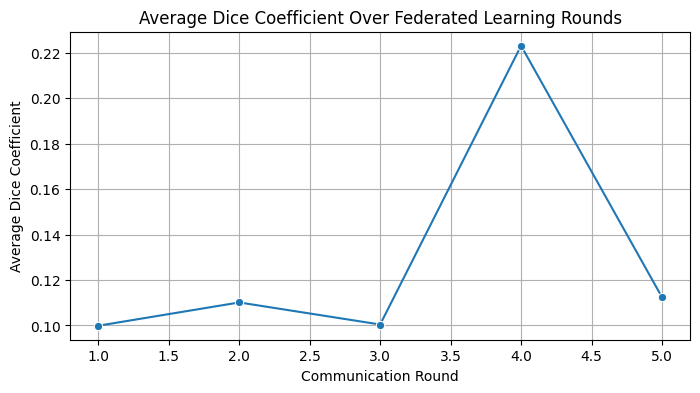

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Average Dice Coefficient
plt.figure(figsize=(8, 4))
sns.lineplot(x='round', y='avg_dice', data=fl_history_df, marker='o')
plt.title('Average Dice Coefficient Over Federated Learning Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Average Dice Coefficient')
plt.grid(True)
plt.show()

## Average IoU Over Federated Learning Rounds

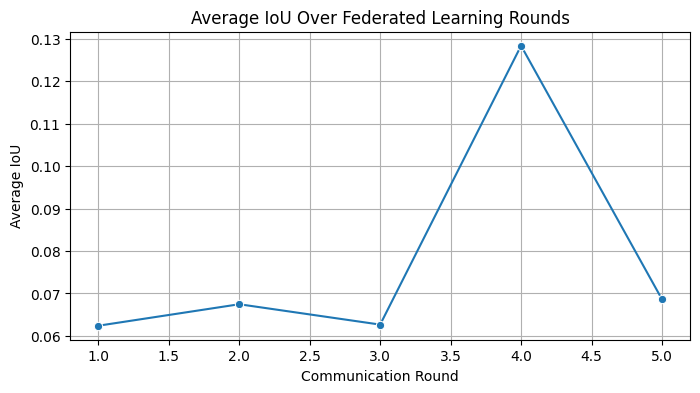

In [55]:
# Plot Average IoU
plt.figure(figsize=(8, 4))
sns.lineplot(x='round', y='avg_iou', data=fl_history_df, marker='o')
plt.title('Average IoU Over Federated Learning Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Average IoU')
plt.grid(True)
plt.show()

## Total Communication Cost

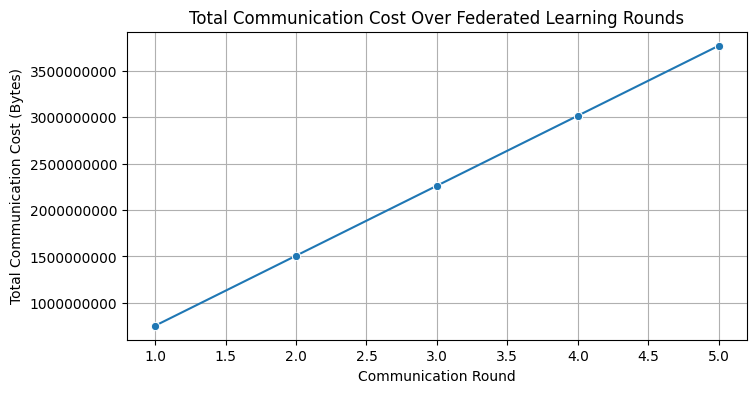

In [56]:
# Plot Total Communication Cost
plt.figure(figsize=(8, 4))
sns.lineplot(x='round', y='total_comm_cost', data=fl_history_df, marker='o')
plt.title('Total Communication Cost Over Federated Learning Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Total Communication Cost (Bytes)')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis
plt.show()

## Round Time

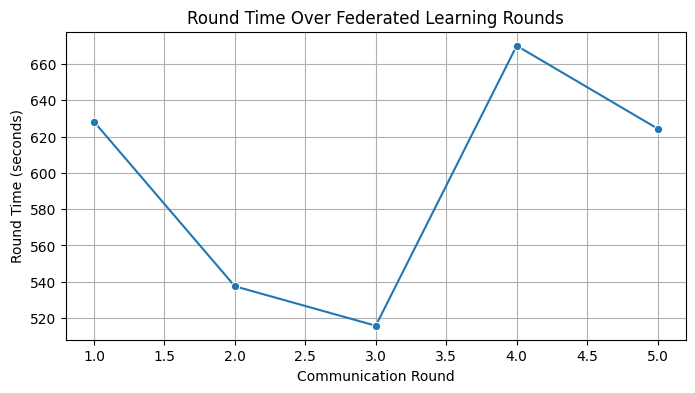

In [57]:
# Plot Round Time
plt.figure(figsize=(8, 4))
sns.lineplot(x='round', y='round_time_sec', data=fl_history_df, marker='o')
plt.title('Round Time Over Federated Learning Rounds')
plt.xlabel('Communication Round')
plt.ylabel('Round Time (seconds)')
plt.grid(True)
plt.show()

## Summary of the implementation of Performance Metrics


Summarize the implementation of performance metrics, the communication cost and response time estimations, and how these will be integrated into the federated training orchestration. Highlight how these metrics contribute to evaluating the distributed learning system.



### Data Analysis Key Findings

*   **Multi-Class Segmentation Metrics Implemented:**
    *   Functions `dice_coefficient_multiclass` and `iou_multiclass` were successfully implemented to calculate multi-class Dice coefficients and Intersection over Union (IoU) for segmentation tasks. These functions correctly handle `argmax` for predictions and include an `epsilon` for numerical stability, preventing division by zero.
    *   A comprehensive `evaluate_model` function was developed, which integrates these individual metric functions to compute average Dice coefficient and IoU across all classes for a given dataset, running the model in evaluation mode without gradient computation.
*   **Communication Cost Estimation:**
    *   A `calculate_communication_cost` function was created, accurately estimating the communication cost in bytes for a model's `state_dict` by summing the byte size of each parameter tensor (`numel() * element_size()`).
*   **Federated Learning Orchestration Established:**
    *   The `FL_orchestrator` function was successfully implemented, managing the entire federated learning process, including global model initialization, client data loader creation, client selection (3 clients per round), distribution of global model, local training (1 epoch per client), server-side aggregation using federated averaging, and systematic metric tracking.
    *   Critical issues were identified and resolved during implementation: a channel mismatch in the `UNet` architecture's `Up` block was corrected, and a type mismatch in the `federated_averaging` function was fixed by explicitly ensuring `torch.float32` for aggregated weights.
*   **Performance and Cost Tracking during Simulation:**
    *   **A 5-round federated learning simulation demonstrated** successful tracking of performance metrics and costs.
    *   The average Dice coefficient showed **an improvement from approximately 0.10 in Round 1 to 0.22 in Round 4**
    *   The total **communication cost progressively increased, reaching 3593.63 MB after 5 rounds**.
    *   Round-wise response times were also successfully recorded, confirming the system's ability to monitor process duration.

### Insights or Next Steps

*   **Performance Improvement:** The observed **Dice and IoU scores (around 0.22) suggest that the segmentation model's performance could be significantly improved**. Future work should focus on hyperparameter tuning (e.g., local epochs, learning rate, client selection strategy), exploring different model architectures, or applying advanced training techniques to enhance segmentation quality.
*   **Communication Optimization:** The cumulative **communication cost of 3.6 GB over just 5 rounds indicates a substantial data transfer overhead**. Investigating and implementing communication-efficient techniques, such as model compression, federated dropout, or sparsification methods, is crucial for scaling the federated learning system to a larger number of clients and rounds.


### **Resource Challenges:**

*   **To implement Speedup:**
Implementing code to measure **'speedup'** in a truly meaningful way, as defined by the ratio of single-node training time to multi-node training time, would be significantly more difficult than the metrics we've implemented so far (Dice, IoU, communication cost, response time).

Here's why:

*   **True Distributed Environment Needed**: Our current FL_orchestrator simulates federated learning on a single Python process within a single machine ( Colab runtime). It doesn't actually distribute the computation across multiple physical or virtual nodes.

* Establishing a Single-Node Baseline: To calculate speedup, requires first need a baseline: the time it takes to train the same model on the entire dataset using a non-federated, single-machine approach. This would involve combining all client data and training a single model locally.

*   **Implementing True Multi-Node Training: The more challenging part is to get the 'multi-node training time'. This would require**:

    Actual Parallel Execution: Modifying the FL_orchestrator to dispatch client training tasks to separate, concurrently running processes or even different machines/GPUs. This involves using libraries like torch.distributed, RPC framework, or setting up a true cluster (e.g., using Kubernetes, Docker, or cloud computing instances with distributed TensorFlow Federated or PyTorch Distributed).
    Inter-process Communication: Managing the actual network communication overhead and synchronization between these separate client processes and the central server process.
    Resource Management: Ensuring each client process has its own isolated resources (CPU, GPU, memory) to prevent bottlenecks that would skew speedup measurements.
  
    In essence, **while the formula for speedup is simple (Time_SingleNode / Time_MultiNode), obtaining the Time_MultiNode value accurately requires transitioning from a simulation within a single environment to a genuinely distributed computing setup**, which is a substantial architectural and implementation change. It goes beyond modifying functions in Python code within a single notebook session and would involve significant infrastructure setup and orchestration.

*  Therefore, to provide accurate speedup metrics, a fundamental shift in how the federated learning simulation is executed would be necessary, making it a considerably more complex task than simply adding another metric calculation to the existing Python code.